<a href="https://colab.research.google.com/github/ElijahMorales04/reu-tribolium-modeling/blob/main/Numerical_Solution_to_Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- parameters ----------
g = 1.0
c_ea, c_el, c_pa = 0.003/14, 0.0179/14, 0.0
b = 20/14
mu_l, mu_a = 0.6053/14, 0.0842/14
s1, s2, s3 = 1, 2, 3

# ---------- grid (CFL: dt <= ds/g) ----------
ds, dt = 0.01, 0.005          # CFL = 0.5 < 1
s = np.arange(0, 4+ds, ds)
t = np.arange(0, 100+dt, dt)

p = np.zeros((len(s), len(t)))
A = np.zeros(len(t))
A[0]  = 50
p[0,0] = b*A[0]

idx_s1, idx_s2, idx_s3 = (np.array([s1,s2,s3])/ds).astype(int)

for n in range(len(t)-1):
    I = p[idx_s1:idx_s2, n].sum()*ds               # ∫_s1^s2 p ds

    # losses per stage (vector)
    loss = np.zeros_like(s)
    loss[s <  s1]              = c_ea*A[n] + c_el*I
    loss[(s>=s1) & (s<s2)]     = mu_l*I
    loss[(s>=s2) & (s<s3)]     = c_pa*A[n]

    # up-wind advection g>0  (vectorised, skip s=0)
    flux = (p[:, n] - np.roll(p[:, n], 1)) / ds
    p[1:, n+1] = p[1:, n] - dt*g*flux[1:] - dt*loss[1:]*p[1:, n]

    # boundary & maturity
    p[0,  n+1] = b*A[n]                               # eggs laid
    adults_in  = g * p[idx_s3, n]                     # mature pupae → adults
    p[idx_s3, n] = 0                                  # remove from grid
    A[n+1]    = A[n] + dt*(adults_in - mu_a*A[n])

print("Block-1 finished without overflow ✔️")

Block-1 finished without overflow ✔️


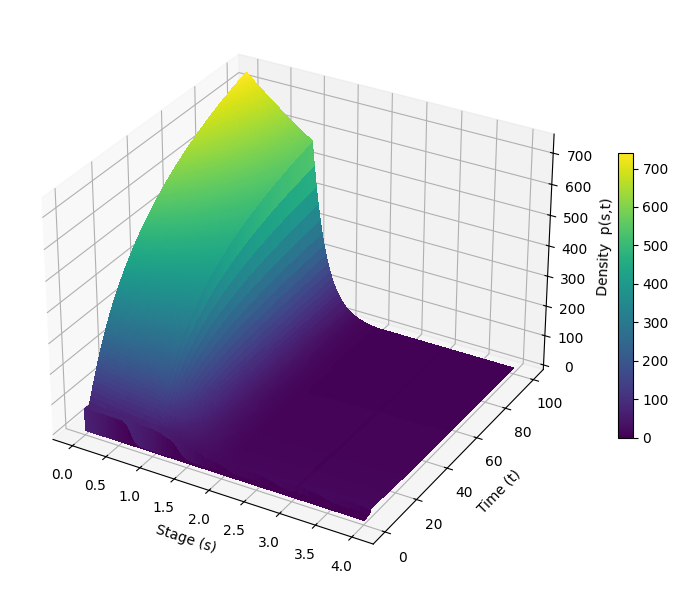

In [23]:
from mpl_toolkits.mplot3d import Axes3D
S, T = np.meshgrid(s, t, indexing='ij')

fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S, T, p,
                       cmap='viridis',
                       rcount=150, ccount=150,  # finer mesh on plot
                       linewidth=0, antialiased=False)

ax.set_xlabel('Stage (s)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Density  p(s,t)')
fig.colorbar(surf, ax=ax, shrink=0.5)
plt.tight_layout()
plt.show()


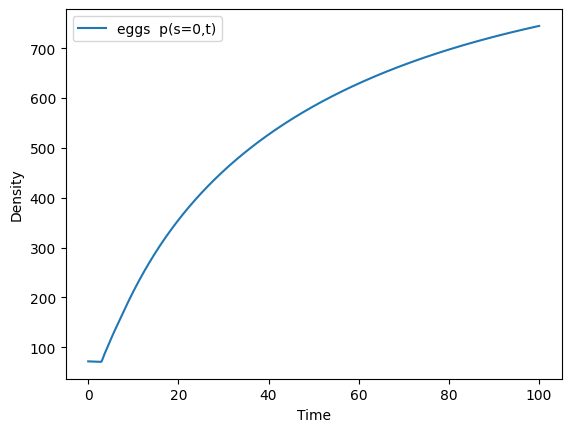

In [24]:
plt.plot(t, p[0], label='eggs  p(s=0,t)')
plt.xlabel('Time'); plt.ylabel('Density'); plt.legend(); plt.show()

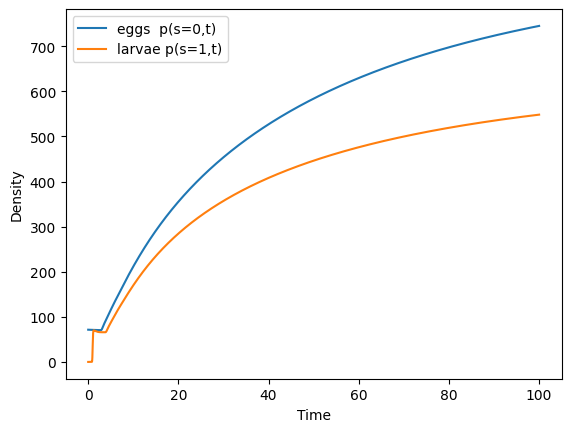

In [25]:
# examples: eggs (s=0) and first‐instar larvae (s≈1)
plt.plot(t, p[0],           label='eggs  p(s=0,t)')
plt.plot(t, p[idx_s1],      label='larvae p(s=1,t)')
plt.xlabel('Time'); plt.ylabel('Density')
plt.legend(); plt.show()

In [ ]:
# ---------- parameters ----------
b   = 1.4286
mu_a = 0.006
mu_l = 0.0432
c_ea = 0.0013
c_el = 0.0002
c_pa = 0.0008
g    = 1.0
s1, s2, s3 = 1, 2, 3

# ---------- grid ----------
ds, dt = 0.01, 0.005
s = np.arange(0, 4+ds, ds)
t = np.arange(0, 100+dt, dt)

p = np.zeros((len(s), len(t)))
A = np.zeros(len(t))
A[0]  = 50
p[0,0] = b*A[0]

idx_s1, idx_s2, idx_s3 = (np.array([s1,s2,s3])/ds).astype(int)

for n in range(len(t)-1):
    I = p[idx_s1:idx_s2, n].sum()*ds
    loss = np.zeros_like(s)
    loss[s <  s1]              = c_ea*A[n] + c_el*I
    loss[(s>=s1) & (s<s2)]     = mu_l*I
    loss[(s>=s2) & (s<s3)]     = c_pa*A[n]

    flux = (p[:, n] - np.roll(p[:, n], 1)) / ds
    p[1:, n+1] = p[1:, n] - dt*g*flux[1:] - dt*loss[1:]*p[1:, n]

    p[0,  n+1] = b*A[n]
    adults_in  = g * p[idx_s3, n]
    p[idx_s3, n] = 0
    A[n+1]    = A[n] + dt*(adults_in - mu_a*A[n])

# --------- plot (matplotlib) ----------
from mpl_toolkits.mplot3d import Axes3D
S, T = np.meshgrid(s, t, indexing='ij')
fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S, T, p, cmap='plasma')
ax.set_xlabel('Stage'); ax.set_ylabel('Time'); ax.set_zlabel('Density')
plt.show()

import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z=p.T, x=s, y=t)])
fig.update_layout(scene=dict(xaxis_title='Stage', yaxis_title='Time', zaxis_title='Density'),
                  width=800, height=700)
fig.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def safe_exp(x, cap=50):      # e^50 ≈ 5e21, huge but finite
    return np.exp(np.clip(x, -cap, cap))

# Parameters
b = 1.4286
mu_a = 0.006
mu_l = 0.0432
c_ea = 0.0013
c_el = 0.0002
c_pa = 0.0008

# Time steps
MaxT = 29
time_steps = 100

# Initialize projection matrix
ProjMatrix = np.zeros((MaxT, MaxT))
ProjMatrix[0, -1] = b  # Corresponds to ProjMatrix(1,29) in MATLAB

# Initialize population matrix
P = np.zeros((MaxT, time_steps + 1))
P[-1, 0] = 50  # Initial condition: 50 adults at t=0

# Time-stepping loop
for n in range(time_steps):  # Adjusted to go up to `time_steps`
    ProjMatrix[1, 0] = safe_exp(-c_ea * P[-1, n] - c_el * np.sum(P[3:12, n]))  # ProjMatrix(2,1)
    ProjMatrix[-1, -1] = 1 - mu_a  # ProjMatrix(29,29)
    for i in range(2, MaxT):
        if i < 4:
            ProjMatrix[i, i - 1] = safe_exp(-c_ea * P[-1, n] - c_el * np.sum(P[3:12, n]))
        elif i < 12:
            ProjMatrix[i, i - 1] = 1 - mu_l
        else:
            ProjMatrix[i, i - 1] = safe_exp(-c_pa * P[-1, n])
    P[:, n + 1] = np.dot(ProjMatrix, P[:, n])

# Plotting
T, S = np.meshgrid(np.arange(time_steps + 1), np.arange(MaxT))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T, S, P, cmap='viridis')
ax.set_xlabel('Time (t)')
ax.set_ylabel('Stage (s)')
ax.set_zlabel('Population Density P(s, t)')
ax.set_title('Population Density Distribution Over Stages and Time')
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()

In [ ]:
import plotly.graph_objects as go

# Create the interactive plot
fig = go.Figure(data=[go.Surface(z=P, x=np.arange(time_steps + 1), y=np.arange(MaxT))])
fig.update_layout(title='Population Density Distribution Over Stages and Time',
                  scene=dict(xaxis_title='Time (t)', yaxis_title='Stage (s)', zaxis_title='Population Density P(s, t)'),
                  autosize=False, width=800, height=800)
fig.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def safe_exp(x, cap=50):      # e^50 ≈ 5e21, huge but finite
    return np.exp(np.clip(x, -cap, cap))

# Parameters
b = 20 / 14
mu_a = 0.08
mu_l = 0.6053
c_ea = 0.0003
c_el = 0.0173
c_pa = 0

# Time steps
MaxT = 29
time_steps = 100

# Initialize projection matrix
ProjMatrix = np.zeros((MaxT, MaxT))
ProjMatrix[0, -1] = b  # Corresponds to ProjMatrix(1,29) in MATLAB

# Initialize population matrix
P = np.zeros((MaxT, time_steps + 1))
P[-1, 0] = 50  # Initial condition: 50 adults at t=0

# Time-stepping loop
for n in range(time_steps):  # Adjusted to go up to `time_steps`
    ProjMatrix[1, 0] = safe_exp(-c_ea * P[-1, n] - c_el * np.sum(P[3:12, n]))  # ProjMatrix(2,1)
    ProjMatrix[-1, -1] = 1 - mu_a  # ProjMatrix(29,29)
    for i in range(2, MaxT):
        if i < 4:
            ProjMatrix[i, i - 1] = safe_exp(-c_ea * P[-1, n] - c_el * np.sum(P[3:12, n]))
        elif i < 12:
            ProjMatrix[i, i - 1] = 1 - mu_l
        else:
            ProjMatrix[i, i - 1] = safe_exp(-c_pa * P[-1, n])
    P[:, n + 1] = np.dot(ProjMatrix, P[:, n])

# Plotting
T, S = np.meshgrid(np.arange(time_steps + 1), np.arange(MaxT))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T, S, P, cmap='viridis')
ax.set_xlabel('Time (t)')
ax.set_ylabel('Stage (s)')
ax.set_zlabel('Population Density P(s, t)')
ax.set_title('Population Density Distribution Over Stages and Time')
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()

In [ ]:
import plotly.graph_objects as go

# Create the interactive plot
fig = go.Figure(data=[go.Surface(z=P, x=np.arange(time_steps + 1), y=np.arange(MaxT))])
fig.update_layout(title='Population Density Distribution Over Stages and Time',
                  scene=dict(xaxis_title='Time (t)', yaxis_title='Stage (s)', zaxis_title='Population Density P(s, t)'),
                  autosize=False, width=800, height=800)
fig.show()